In [169]:
import pandas as pd
from arch import arch_model
import numpy as np
import random
from scipy.stats import norm
import matplotlib.pyplot as plt


In [117]:
# daily price data of msft
import quandl
quandl.ApiConfig.api_key = "YsgeJmyZtvDmyVdYinwf"
price_daily = quandl.get_table('WIKI/PRICES', \
                        qopts = { 'columns': ['ticker', 'date', 'close'] }, \
                        ticker = ['MSFT'], \
                        date = { 'gte': '2006-01-01', 'lte': '2016-12-31' })
print(price_daily.shape)
price_daily.head()

(2769, 3)


,ticker,date,close
None,,,
0,MSFT,2006-01-03,26.84
1,MSFT,2006-01-04,26.97
2,MSFT,2006-01-05,26.99
3,MSFT,2006-01-06,26.91
4,MSFT,2006-01-09,26.86


Text(0.5,1,u'MSFT Price')

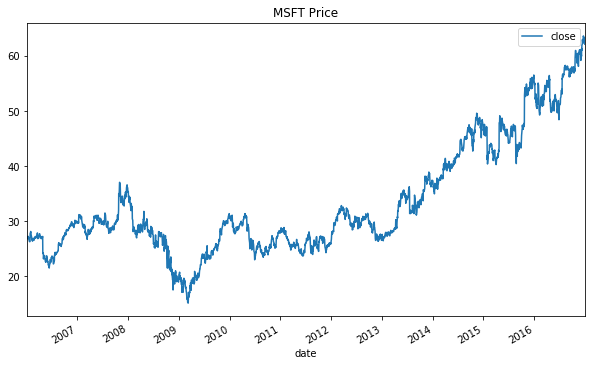

In [118]:
# daily price data of msft 

%matplotlib inline
import seaborn as sns
sns.mpl.rcParams['figure.figsize'] = (10.0, 6.0)
sns.mpl.rcParams['savefig.dpi'] = 90
price_daily.plot(x='date', y='close')
plt.title('MSFT Price')
# plt.savefig('msft_price.png')

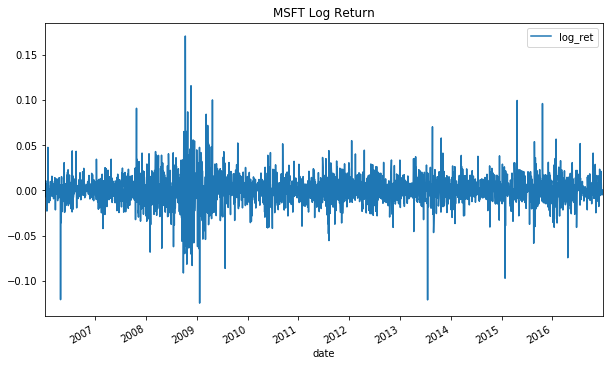

In [120]:
# plot log_returns

# log_return = log(pi/pj) = log(pi) - log(pj)
log_pj = list(np.log(price_daily['close']))
log_pi = log_pj[1:]
log_pi.append(0)
assert len(log_pi) == len(log_pj)
price_daily['log_ret'] = np.array(log_pi) - np.array(log_pj)
price_daily = price_daily[:-1]
price_daily.plot(x='date',y = 'log_ret')
plt.title('MSFT Log Return')
# plt.savefig('msft_log_ret.png')
plt.show()

In [121]:
sig_0_daily = np.std(price_daily['log_ret'])
mu_daily = np.mean(price_daily['log_ret'])
print "mu for daily price log return is: ", mu_daily
print "sd for daily price log return is: ", sig_0_daily

mu for daily price log return is:  0.000307789248863
sd for daily price log return is:  0.0174377434868


In [127]:
price = pd.read_csv('msft20150102priceallday_filtered.txt', header = None, names = ['Datetime','Price'], index_col = 0)

price.shape

(22088, 1)

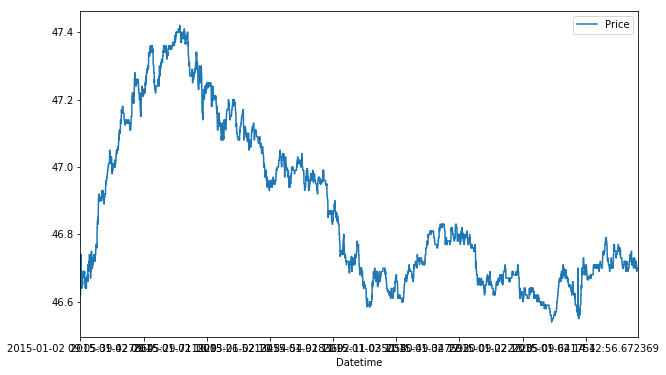

In [128]:
# plot prices

%matplotlib inline
import seaborn
seaborn.mpl.rcParams['figure.figsize'] = (10.0, 6.0)
seaborn.mpl.rcParams['savefig.dpi'] = 90
price.plot()

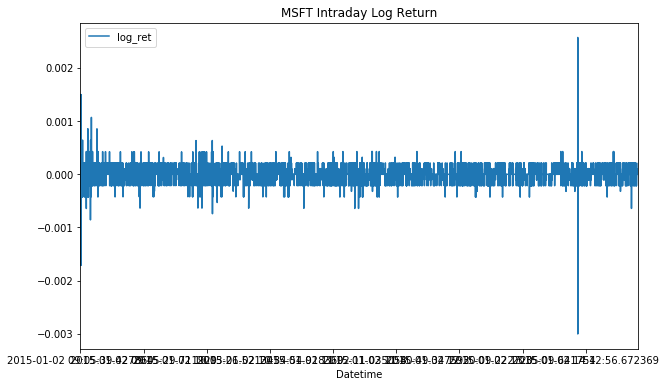

In [129]:
# plot log_returns

log_pj = list(np.log(price['Price']))
log_pi = log_pj[1:]
log_pi.append(0)
assert len(log_pi) == len(log_pj)
price['log_ret'] = np.array(log_pi) - np.array(log_pj)
price = price[:-1]
price.plot(y = 'log_ret')
plt.title('MSFT Intraday Log Return')
# plt.savefig('msft_log_ret_HF.png')

8.73201841086e-08
7.95384050606e-05


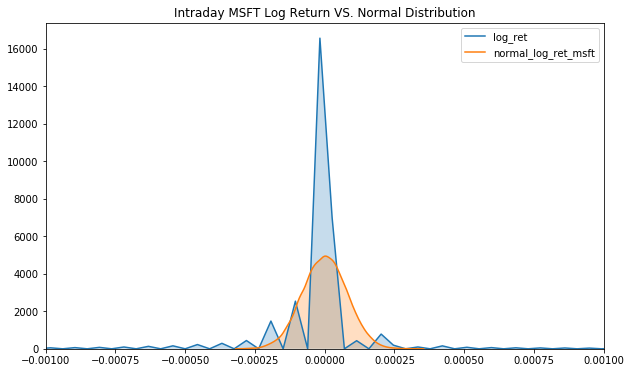

In [132]:
# fattail on msft hf data
sig_0 = np.std(price['log_ret'])
mu = np.mean(price['log_ret'])
print mu
print sig_0
price['normal_log_ret_msft'] = list(mu+sig_0*np.random.normal(size=len(price)))
fig, ax = plt.subplots()
# sns.distplot(price['log_ret'], ax = ax)
# sns.distplot(price['normal_log_ret'],ax = ax)
sns.kdeplot(price['log_ret'],shade=True,ax=ax)
sns.kdeplot(price['normal_log_ret_msft'], shade=True,ax=ax)
plt.xlim(-0.001, 0.001)
plt.title('Intraday MSFT Log Return VS. Normal Distribution')
# plt.savefig('Intraday_MSFT_logret_vs_normal_big.png')
plt.show()

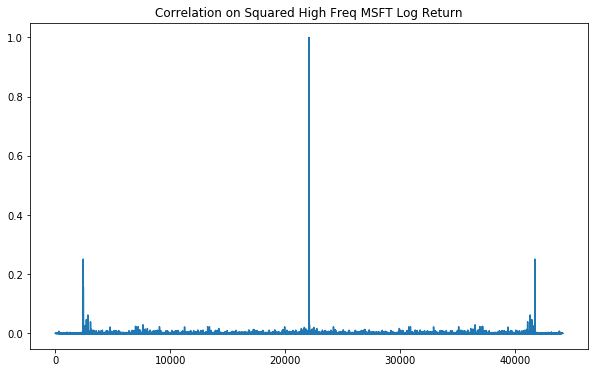

In [38]:
# test for autocorrelation on MSFT high freq data

y = price['log_ret']**2
y = y - np.mean(y)
norm = np.sum(y ** 2)
correlated = np.correlate(y, y, mode='full')/norm
idx = np.argsort(correlated)[-1]
# np.corrcoef(y)
# print 'highest correlation is at index ', idx, 'which has value: ', correlated[idx]
plt.plot(correlated)
plt.title('Correlation on Squared High Freq MSFT Log Return')
plt.savefig('corr_msft_intraday.png')

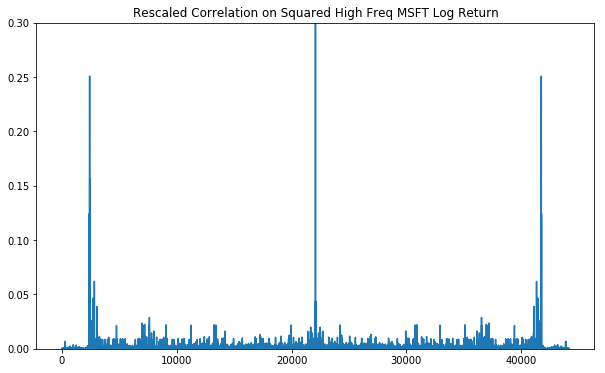

In [39]:
# zoom in
# test for autocorrelation on MSFT data

y = price['log_ret']**2
y = y - np.mean(y)
norm = np.sum(y ** 2)
correlated = np.correlate(y, y, mode='full')/norm
idx = np.argsort(correlated)[-1]
plt.plot(correlated)
# plt.xlim(2600,6000)
plt.ylim(0, 0.3)
plt.title('Rescaled Correlation on Squared High Freq MSFT Log Return')
plt.savefig('rescaled_corr_msft_intraday.png')

In [177]:
# fit GARCH model

def fit_GARCH(returns, num_train):
    garch11 = arch_model(returns[:num_train], p=1, q=1)
    res = garch11.fit(update_freq=10)
    print(res.summary())
    
print "Fitting GARCH to daily_price return..."
returns = np.array(price_daily['log_ret'])

num_train = int(len(price_daily)*0.8)
num_sim = int(len(price_daily)*0.2)

fit_GARCH(returns, num_train)
print "num_train is: ", num_train

Fitting GARCH to daily_price return...
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6038.98432806
            Iterations: 13
            Function evaluations: 120
            Gradient evaluations: 9
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:                6038.98
Distribution:                  Normal   AIC:                          -12070.0
Method:            Maximum Likelihood   BIC:                          -12047.2
                                        No. Observations:                 2213
Date:                Tue, May 08 2018   Df Residuals:                     2209
Time:                        13:59:21   Df Model:                            4
                                 Mean Model

In [178]:
# GARCH model on high frequency intraday price log return

print "Fitting GARCH to high frequency price return..."

num_train = int(len(price)*0.8)
num_sim = int(len(price)*0.2)

returns = np.array(price['log_ret'])
fit_GARCH(returns, num_train)
print "num_train is: ", num_train

Fitting GARCH to high frequency price return...
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -143675.167311
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                143675.
Distribution:                  Normal   AIC:                          -287342.
Method:            Maximum Likelihood   BIC:                          -287311.
                                        No. Observations:                17669
Date:                Tue, May 08 2018   Df Residuals:                    17665
Time:                        14:00:07   Df Model:                            4
                                  Mean 

/anaconda2/lib/python2.7/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


In [179]:
# get parameters from the above table

params_intraday = [6.1064e-10, 0.0500, 0.8500]
params_daily = [6.3587e-06, 0.0500, 0.9300]

# fig = res.plot(annualize='D')

In [154]:
# out of sample test

def test(params, data, num_sim, num_train):
    [omega, alpha, beta] = params
    data = data[:num_train]
    sig = np.std(data)
    mu = np.mean(data)
    # initialize with last return and past sigma
    res_r = [data[-1]]
    res_sig = [sig]
    
    def get_next_sig(sig_curr, ret_curr):
        return np.sqrt(omega + alpha * ret_curr**2 + beta * sig_curr**2)
    def get_next_ret(sig):
        return np.random.normal(mu, sig, 1)
    
    for i in range(num_sim):
        sig_curr = get_next_sig(res_sig[-1], res_r[-1])
        res_sig.append(sig_curr)
        ret_curr = get_next_ret(sig_curr)
        res_r.append(ret_curr)
#     plt.plot(res_r)
#     plt.show()
    return res_r
    

# plot the simulated result together with the actual value to compare
def plot_sim_res(data, res_r, title, num_train, savename, save = False):
    num_siz = len(res_r)
    plt.plot(data[num_train:num_train + num_sim], label = "actual")
    plt.plot(res_r, label = "simulated")
    plt.legend()
    plt.title(title)
    if save:
        plt.savefig(savename+".png")
    plt.show()


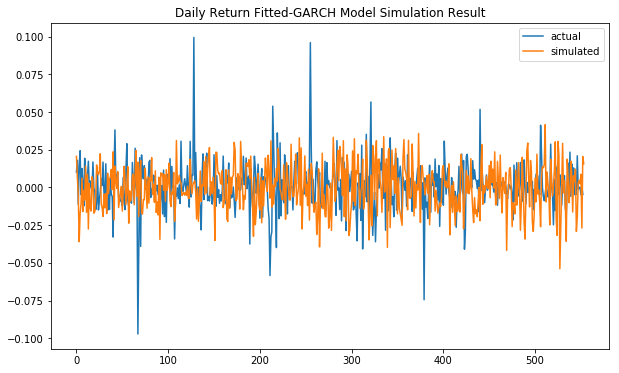

In [181]:
# out of sample testing on daily price data
# where the first 1000 data points are used in building GARCH and 
# do a simulation of 500

data = price_daily['log_ret'].tolist()

num_train = int(len(price_daily)*0.8)
num_sim = int(len(price_daily)*0.2)

res_r_daily = test(params_daily, data, num_sim, num_train)
title = "Daily Return Fitted-GARCH Model Simulation Result"
plot_sim_res(data, res_r_daily, title, num_train, savename = "daily_return_sim", save = False)

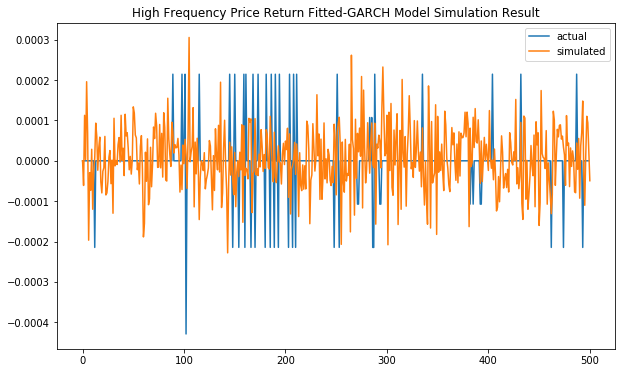

In [183]:
data = price['log_ret'].tolist()

num_train = int(len(price)*0.8)
# num_sim = int(len(price)*0.2) # too many
num_sim = 500

res_r = test(params_intraday, data, num_sim, num_train)
title = "High Frequency Price Return Fitted-GARCH Model Simulation Result"
plot_sim_res(data, res_r, title, num_train, savename = "hf_return_sim", save = False)
